Target Construction

In [1]:
import os
import csv

# ========= PATH CONFIG =========
INPUT_CSV = "/content/drive/MyDrive/PR_Sky/SASS/Data/lounge.csv"
OUT_DIR   = "/content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS"
os.makedirs(OUT_DIR, exist_ok=True)

OUTPUT_CSV = os.path.join(OUT_DIR, "lounge_with_target.csv")

# ========= LOAD & TARGET CONSTRUCTION =========
rows = []
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    header = reader.fieldnames

    if header is None:
        raise ValueError("No header found in input CSV!")

    for row in reader:
        rating_raw = row.get("overall_rating", "").strip()
        if rating_raw == "":
            # skip rows with missing overall_rating
            continue

        try:
            rating_val = float(rating_raw)
        except ValueError:
            # skip rows with non-numeric overall_rating
            continue

        # ----- Map rating to satisfaction_class -----
        # 0 → Negative (1–4)
        # 1 → Neutral  (5–7)
        # 2 → Positive (8–10)
        if rating_val <= 4:
            sc = 0
        elif rating_val <= 7:
            sc = 1
            # 5–7 → Neutral
        else:
            sc = 2

        row["overall_rating"] = rating_val      # numeric
        row["satisfaction_class"] = sc          # new target
        rows.append(row)

# Ensure target column is in header
if "satisfaction_class" not in header:
    header = header + ["satisfaction_class"]

# ========= SAVE OUTPUT CSV =========
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    for r in rows:
        writer.writerow(r)

# ========= PRINT STATS =========
row_count = len(rows)
col_count = len(header)
print("Final dataset shape:", (row_count, col_count))

# Class distribution
c0 = c1 = c2 = 0
for r in rows:
    sc = r["satisfaction_class"]
    if sc == 0:
        c0 += 1
    elif sc == 1:
        c1 += 1
    elif sc == 2:
        c2 += 1

total = c0 + c1 + c2
if total == 0:
    print("No valid rows after filtering!")
else:
    p0 = c0 / total
    p1 = c1 / total
    p2 = c2 / total

    print("Class distribution (counts):")
    print("  0 (Negative):", c0)
    print("  1 (Neutral) :", c1)
    print("  2 (Positive):", c2)

    print("\nClass distribution (proportions):")
    print("  0 (Negative):", round(p0, 3))
    print("  1 (Neutral) :", round(p1, 3))
    print("  2 (Positive):", round(p2, 3))

print("\nSaved file at:")
print(" ", OUTPUT_CSV)


Final dataset shape: (2259, 22)
Class distribution (counts):
  0 (Negative): 1823
  1 (Neutral) : 388
  2 (Positive): 48

Class distribution (proportions):
  0 (Negative): 0.807
  1 (Neutral) : 0.172
  2 (Positive): 0.021

Saved file at:
  /content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS/lounge_with_target.csv


Numeric Features (for Gaussian NB)

In [3]:
import os
import csv
import random

# ================== PATHS ==================
BASE_DIR   = "/content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS"
INPUT_CSV  = os.path.join(BASE_DIR, "lounge_with_target.csv")

OUT_TRAIN  = os.path.join(BASE_DIR, "lounge_train_proc.csv")
OUT_TEST   = os.path.join(BASE_DIR, "lounge_test_proc.csv")

os.makedirs(BASE_DIR, exist_ok=True)

TARGET_COL = "satisfaction_class"

# ================== LOAD DATA ==================
rows = []
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    header = r.fieldnames
    for row in r:
        rows.append(row)

if not rows:
    raise ValueError("No rows loaded from input CSV!")

print("Loaded shape:", (len(rows), len(header)))
print("Columns:", header)

if TARGET_COL not in header:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Run Phase 1 first.")

# ================== CLEAN TARGET ==================
clean = []
for row in rows:
    v = row.get(TARGET_COL, "")
    ok = True
    try:
        v2 = float(v)
        if v2 == int(v2):
            v2 = int(v2)
        else:
            ok = False
    except:
        ok = False

    if ok and v2 in (0, 1, 2):
        row[TARGET_COL] = v2
        clean.append(row)

rows = clean
print("Rows after target cleaning:", len(rows))

# ================== AUTO-DETECT NUMERIC RATING FEATURES ==================
# Take ALL columns that end with "_rating" (including overall_rating),
# and are not the target column.
numeric_cols = [
    c for c in header
    if c.endswith("_rating") and c != TARGET_COL
]

if not numeric_cols:
    raise ValueError(
        "No numeric rating features found automatically. "
        "Check if your rating columns end with '_rating'."
    )

print("\nInitial numeric feature candidates found:", numeric_cols)

# ================== PARSE NUMERIC VALUES & CHECK MISSINGNESS ==================
n = len(rows)
missing_counts = {c: 0 for c in numeric_cols}

for row in rows:
    for c in numeric_cols:
        txt = row.get(c, "")
        try:
            val = float(txt)
            row[c] = val
        except:
            row[c] = None
            missing_counts[c] += 1

missing_info = []
for c in numeric_cols:
    miss_pct = missing_counts[c] / n if n > 0 else 0.0
    missing_info.append((c, miss_pct))

missing_info.sort(key=lambda t: t[1], reverse=True)

print("\nMissingness (numeric features):")
for c, pct in missing_info:
    print(f"  {c}: {pct:.3f}")

# Drop features with > 50% missing
features = [c for c, pct in missing_info if pct <= 0.5]

if not features:
    raise ValueError(
        "All numeric features have >50% missing values. "
        "Adjust threshold or inspect the data."
    )

print("\nSelected numeric features after dropping >50% missing:")
print(features)

# ================== CLASS DISTRIBUTION (OVERALL) ==================
c0 = c1 = c2 = 0
for row in rows:
    y = row[TARGET_COL]
    if y == 0:
        c0 += 1
    elif y == 1:
        c1 += 1
    elif y == 2:
        c2 += 1

total = c0 + c1 + c2
print("\nClass distribution (counts):")
print("  0:", c0)
print("  1:", c1)
print("  2:", c2)

if total > 0:
    print("\nClass distribution (proportions):")
    print("  0:", round(c0 / total, 3))
    print("  1:", round(c1 / total, 3))
    print("  2:", round(c2 / total, 3))
else:
    print("\nNo data to compute class distribution.")

# ================== STRATIFIED SPLIT (80/20) ==================
idx0, idx1, idx2 = [], [], []
for i, row in enumerate(rows):
    y = row[TARGET_COL]
    if y == 0:
        idx0.append(i)
    elif y == 1:
        idx1.append(i)
    elif y == 2:
        idx2.append(i)

random.seed(42)
random.shuffle(idx0)
random.shuffle(idx1)
random.shuffle(idx2)

def split_idx(lst, test_ratio=0.20):
    n = len(lst)
    n_test = int(n * test_ratio)
    te = lst[:n_test]
    tr = lst[n_test:]
    return tr, te

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

train_rows = [rows[i] for i in train_idx]
test_rows  = [rows[i] for i in test_idx]

print("\nStratified split sizes:")
print("  Train:", len(train_rows))
print("  Test :", len(test_rows))

# ================== MEDIAN IMPUTATION (TRAIN-BASED) ==================
medians = {}
for c in features:
    vals = []
    for row in train_rows:
        v = row.get(c, None)
        if v is not None:
            vals.append(v)
    vals.sort()
    if not vals:
        med = 0.0
    else:
        m = len(vals)
        mid = m // 2
        if m % 2 == 1:
            med = vals[mid]
        else:
            med = (vals[mid - 1] + vals[mid]) / 2.0
    medians[c] = med

print("\nFeature medians (computed from TRAIN only):")
for c in features:
    print(f"  {c}: {medians[c]}")

# Impute in TRAIN
for row in train_rows:
    for c in features:
        if row.get(c, None) is None:
            row[c] = medians[c]

# Impute in TEST using same medians
for row in test_rows:
    for c in features:
        if row.get(c, None) is None:
            row[c] = medians[c]

# ================== SAVE TRAIN / TEST CSVs ==================
out_header = features + [TARGET_COL]  # numeric features + target

with open(OUT_TRAIN, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=out_header)
    w.writeheader()
    for row in train_rows:
        out_row = {c: row.get(c, "") for c in out_header}
        w.writerow(out_row)

with open(OUT_TEST, "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=out_header)
    w.writeheader()
    for row in test_rows:
        out_row = {c: row.get(c, "") for c in out_header}
        w.writerow(out_row)

print("\nSaved preprocessed numeric datasets:")
print("  Train:", OUT_TRAIN)
print("  Test :", OUT_TEST)

print("\nFinal shapes (numeric view):")
print("  X_train:", (len(train_rows), len(features)))
print("  X_test :", (len(test_rows), len(features)))


Loaded shape: (2259, 22)
Columns: ['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'lounge_name', 'airport', 'lounge_type', 'date_visit', 'type_traveller', 'overall_rating', 'comfort_rating', 'cleanliness_rating', 'bar_beverages_rating', 'catering_rating', 'washrooms_rating', 'wifi_connectivity_rating', 'staff_service_rating', 'recommended', 'satisfaction_class']
Rows after target cleaning: 2259

Initial numeric feature candidates found: ['overall_rating', 'comfort_rating', 'cleanliness_rating', 'bar_beverages_rating', 'catering_rating', 'washrooms_rating', 'wifi_connectivity_rating', 'staff_service_rating']

Missingness (numeric features):
  washrooms_rating: 0.012
  wifi_connectivity_rating: 0.005
  staff_service_rating: 0.004
  bar_beverages_rating: 0.002
  catering_rating: 0.001
  overall_rating: 0.000
  comfort_rating: 0.000
  cleanliness_rating: 0.000

Selected numeric features after dropping >50% missing:
['washrooms_rating', 'wifi_connectivity_ra

In [4]:
!pip install gensim scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.1 MB/s eta 0:00:00


In [5]:
import os
import csv
import re
import math
import random
import numpy as np

from gensim.models import Word2Vec
from sklearn.cluster import MiniBatchKMeans

# ================== PATHS ==================
BASE_DIR   = "/content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS"
INPUT_CSV  = os.path.join(BASE_DIR, "lounge_with_target.csv")

# Optional splits for inspection
TRAIN_SPLIT_CSV = os.path.join(BASE_DIR, "lounge_text_train_split.csv")
TEST_SPLIT_CSV  = os.path.join(BASE_DIR, "lounge_text_test_split.csv")

# Final BoC + labels
X_TRAIN_NPY = os.path.join(BASE_DIR, "X_train_boc.npy")
X_TEST_NPY  = os.path.join(BASE_DIR, "X_test_boc.npy")
Y_TRAIN_NPY = os.path.join(BASE_DIR, "y_train.npy")
Y_TEST_NPY  = os.path.join(BASE_DIR, "y_test.npy")

os.makedirs(BASE_DIR, exist_ok=True)

TARGET_COL = "satisfaction_class"
TEXT_COL   = "content"

# ================== LOAD DATA ==================
rows = []
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    header = reader.fieldnames
    for row in reader:
        rows.append(row)

if not rows:
    raise ValueError("No rows loaded from lounge_with_target.csv!")

print("Loaded shape:", (len(rows), len(header)))
print("Columns:", header)

if TARGET_COL not in header:
    raise ValueError(f"Target column '{TARGET_COL}' not found!")
if TEXT_COL not in header:
    raise ValueError(f"Text column '{TEXT_COL}' not found!")

# ================== CLEAN TARGET + TEXT ==================
valid_rows = []
for row in rows:
    # --- target clean ---
    v = row.get(TARGET_COL, "")
    ok = True
    try:
        vv = float(v)
        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False

    # --- text clean ---
    txt = row.get(TEXT_COL, "")
    txt = "" if txt is None else str(txt).strip()

    if ok and (vv in (0, 1, 2)) and (txt != ""):
        row[TARGET_COL] = vv
        row[TEXT_COL]   = txt
        valid_rows.append(row)

rows = valid_rows
print("Rows after target + text filtering:", len(rows))

# ================== CLASS DISTRIBUTION ==================
c0 = c1 = c2 = 0
for row in rows:
    y = row[TARGET_COL]
    if y == 0: c0 += 1
    elif y == 1: c1 += 1
    elif y == 2: c2 += 1

total = c0 + c1 + c2
print("\nClass distribution (counts) after text clean:")
print("  0:", c0)
print("  1:", c1)
print("  2:", c2)

if total > 0:
    print("\nClass distribution (proportions):")
    print("  0:", round(c0 / total, 3))
    print("  1:", round(c1 / total, 3))
    print("  2:", round(c2 / total, 3))

# ================== BUILD TEXT + LABEL ARRAYS ==================
texts = [row[TEXT_COL] for row in rows]
labels = [row[TARGET_COL] for row in rows]

# ================== STRATIFIED SPLIT (80/20) ==================
idx0, idx1, idx2 = [], [], []
for i, y in enumerate(labels):
    if y == 0:
        idx0.append(i)
    elif y == 1:
        idx1.append(i)
    elif y == 2:
        idx2.append(i)

random.seed(42)
random.shuffle(idx0)
random.shuffle(idx1)
random.shuffle(idx2)

def split_idx(lst, test_ratio=0.20):
    n = len(lst)
    n_test = int(n * test_ratio)
    test_ids = lst[:n_test]
    train_ids = lst[n_test:]
    return train_ids, test_ids

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

X_train_text = [texts[i] for i in train_idx]
X_test_text  = [texts[i] for i in test_idx]
y_train      = [labels[i] for i in train_idx]
y_test       = [labels[i] for i in test_idx]

print("\nTrain size:", len(X_train_text), " Test size:", len(X_test_text))

# Check class distribution in splits
def count_classes(y_list):
    a = b = c = 0
    for y in y_list:
        if y == 0: a += 1
        elif y == 1: b += 1
        elif y == 2: c += 1
    return a, b, c

tr_c0, tr_c1, tr_c2 = count_classes(y_train)
te_c0, te_c1, te_c2 = count_classes(y_test)

print("\nClass counts (TRAIN):")
print("  0:", tr_c0)
print("  1:", tr_c1)
print("  2:", tr_c2)

print("\nClass counts (TEST):")
print("  0:", te_c0)
print("  1:", te_c1)
print("  2:", te_c2)

# ================== OPTIONAL: SAVE SPLITS AS CSV ==================
with open(TRAIN_SPLIT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([TEXT_COL, TARGET_COL])
    for t, y in zip(X_train_text, y_train):
        w.writerow([t, y])

with open(TEST_SPLIT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow([TEXT_COL, TARGET_COL])
    for t, y in zip(X_test_text, y_test):
        w.writerow([t, y])

print("\nSaved raw text splits to:")
print("  ", TRAIN_SPLIT_CSV)
print("  ", TEST_SPLIT_CSV)

# ================== TOKENIZATION ==================
token_pat = re.compile(r"[A-Za-z0-9]+")

def tokenize(text):
    return token_pat.findall(str(text).lower())

train_tokens = [tokenize(t) for t in X_train_text]
test_tokens  = [tokenize(t) for t in X_test_text]

# ================== TRAIN WORD2VEC ==================
w2v = Word2Vec(
    sentences=train_tokens,
    vector_size=200,
    window=5,
    min_count=2,
    workers=4,
    sg=0,          # CBOW
    negative=10,
    epochs=10,
    seed=42
)

vocab_words = list(w2v.wv.key_to_index.keys())
V = len(vocab_words)

if V == 0:
    raise RuntimeError("Word2Vec vocabulary is empty. Check min_count or training data.")

W = w2v.wv[vocab_words]   # shape: (V, dim)
dim = W.shape[1]

# ================== CLUSTER EMBEDDINGS -> BoC ==================
K = int(max(100, min(500, math.ceil(math.sqrt(V) * 2))))
print(f"\nWord2Vec vocab size: {V}, dim: {dim} -> Clustering into K={K} centroids")

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=2048,
    random_state=42,
    n_init=10
)
kmeans.fit(W)

word_to_cluster = {}
for i, w in enumerate(vocab_words):
    word_to_cluster[w] = int(kmeans.labels_[i])

def docs_to_boc_dense(docs_tokens, word2clust, K):
    n_docs = len(docs_tokens)
    M = np.zeros((n_docs, K), dtype=np.float32)
    for i, toks in enumerate(docs_tokens):
        for t in toks:
            cid = word2clust.get(t, None)
            if cid is not None:
                M[i, cid] += 1.0
    return M

X_train_boc = docs_to_boc_dense(train_tokens, word_to_cluster, K)
X_test_boc  = docs_to_boc_dense(test_tokens,  word_to_cluster, K)

print("\nBoC shapes:")
print("  X_train_boc:", X_train_boc.shape)
print("  X_test_boc :", X_test_boc.shape)

# ================== SAVE ARRAYS ==================
np.save(X_TRAIN_NPY, X_train_boc)
np.save(X_TEST_NPY,  X_test_boc)
np.save(Y_TRAIN_NPY, np.array(y_train, dtype=np.int32))
np.save(Y_TEST_NPY,  np.array(y_test,  dtype=np.int32))

print("\nSaved numpy arrays:")
print("  X_train_boc.npy ->", X_TRAIN_NPY)
print("  X_test_boc.npy  ->", X_TEST_NPY)
print("  y_train.npy     ->", Y_TRAIN_NPY)
print("  y_test.npy      ->", Y_TEST_NPY)


Loaded shape: (2259, 22)
Columns: ['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'lounge_name', 'airport', 'lounge_type', 'date_visit', 'type_traveller', 'overall_rating', 'comfort_rating', 'cleanliness_rating', 'bar_beverages_rating', 'catering_rating', 'washrooms_rating', 'wifi_connectivity_rating', 'staff_service_rating', 'recommended', 'satisfaction_class']
Rows after target + text filtering: 2259

Class distribution (counts) after text clean:
  0: 1823
  1: 388
  2: 48

Class distribution (proportions):
  0: 0.807
  1: 0.172
  2: 0.021

Train size: 1809  Test size: 450

Class counts (TRAIN):
  0: 1459
  1: 311
  2: 39

Class counts (TEST):
  0: 364
  1: 77
  2: 9

Saved raw text splits to:
   /content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS/lounge_text_train_split.csv
   /content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS/lounge_text_test_split.csv

Word2Vec vocab size: 4309, dim: 200 -> Clustering into K=132 centroids

SASS Balancing — Lounge Dataset

==== NUMERIC TRAIN: Loading lounge_train_proc.csv ====
Numeric feature columns: ['washrooms_rating', 'wifi_connectivity_rating', 'staff_service_rating', 'bar_beverages_rating', 'catering_rating', 'overall_rating', 'comfort_rating', 'cleanliness_rating']
Numeric X_train shape: (1809, 8)
Numeric y_train shape: (1809,)
Numeric train class counts BEFORE SASS: {0: 1459, 1: 311, 2: 39}

[ SASS ] Original class counts: {np.int64(0): np.int64(1459), np.int64(1): np.int64(311), np.int64(2): np.int64(39)}
[ SASS ] Target per class: {np.int64(0): np.int64(1459), np.int64(1): np.int64(1459), np.int64(2): np.int64(1459)}
[ SASS ] Class 1: generating 1148 synthetic samples
[ SASS ] Class 2: generating 1420 synthetic samples
[ SASS ] New class counts: {0: 1459, 1: 1459, 2: 1459}
Numeric train class counts AFTER SASS: {0: 1459, 1: 1459, 2: 1459}


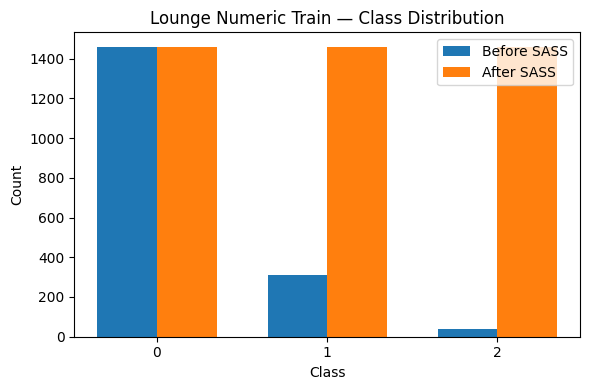


Saving numeric SASS-balanced CSV to: /content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS/lounge_train_proc_sass.csv
Saved: /content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS/lounge_train_proc_sass.csv

==== TEXT BoC TRAIN: Loading X_train_boc.npy & y_train.npy ====
Text X_train_boc shape: (1809, 132)
Text y_train shape: (1809,)
Text train class counts BEFORE SASS: {0: 1459, 1: 311, 2: 39}

[ SASS ] Original class counts: {np.int32(0): np.int64(1459), np.int32(1): np.int64(311), np.int32(2): np.int64(39)}
[ SASS ] Target per class: {np.int32(0): np.int64(1459), np.int32(1): np.int64(1459), np.int32(2): np.int64(1459)}
[ SASS ] Class 1: generating 1148 synthetic samples
[ SASS ] Class 2: generating 1420 synthetic samples
[ SASS ] New class counts: {0: 1459, 1: 1459, 2: 1459}
Text train class counts AFTER SASS: {0: 1459, 1: 1459, 2: 1459}


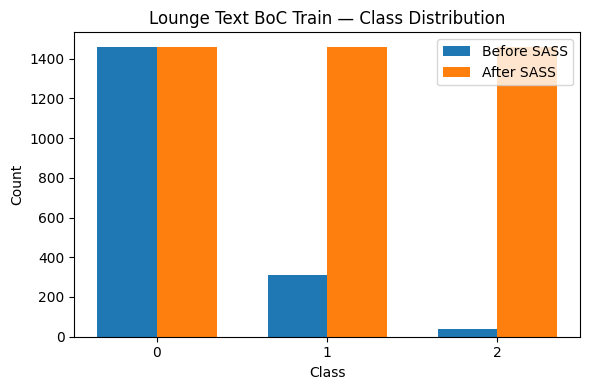


Saved SASS-balanced text arrays:
  X_train_boc_sass.npy -> /content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS/X_train_boc_sass.npy
  y_train_sass.npy     -> /content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS/y_train_sass.npy


In [6]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# ================== PATHS ==================
BASE_DIR = "/content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS"

# Numeric train (from Phase 2)
NUMERIC_TRAIN_CSV      = os.path.join(BASE_DIR, "lounge_train_proc.csv")
NUMERIC_TRAIN_SASS_CSV = os.path.join(BASE_DIR, "lounge_train_proc_sass.csv")

# Text BoC train (from Phase 2B)
X_TRAIN_BOC_NPY = os.path.join(BASE_DIR, "X_train_boc.npy")
Y_TRAIN_NPY     = os.path.join(BASE_DIR, "y_train.npy")

X_TRAIN_BOC_SASS_NPY = os.path.join(BASE_DIR, "X_train_boc_sass.npy")
Y_TRAIN_SASS_NPY     = os.path.join(BASE_DIR, "y_train_sass.npy")

TARGET_COL = "satisfaction_class"
os.makedirs(BASE_DIR, exist_ok=True)

# ================== UTILS ==================
def compute_class_counts(y):
    classes, counts = np.unique(y, return_counts=True)
    return {int(c): int(n) for c, n in zip(classes, counts)}

def plot_class_distribution(before_counts, after_counts, title_prefix):
    classes = sorted(set(before_counts.keys()) | set(after_counts.keys()))
    before_vals = [before_counts.get(c, 0) for c in classes]
    after_vals  = [after_counts.get(c, 0) for c in classes]

    x = np.arange(len(classes))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, before_vals, width, label="Before SASS")
    plt.bar(x + width/2, after_vals,  width, label="After SASS")
    plt.xticks(x, [str(c) for c in classes])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} — Class Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()

def sass_oversample(X, y, smoothing=0.05, random_state=42, target_strategy="max"):
    """
    Smooth Adaptive Synthetic Sampling (SASS).

    - Oversamples minority classes up to max class size
    - Each synthetic point:
        * interpolation between two same-class neighbors
        * + Gaussian noise scaled by feature std
        * clipped to [min, max] per feature
    """
    rng = np.random.RandomState(random_state)
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y)

    classes, counts = np.unique(y, return_counts=True)

    if target_strategy == "max":
        target_n = counts.max()
        target_per_class = {c: target_n for c in classes}
    else:
        raise ValueError("Only 'max' target_strategy implemented.")

    print("\n[ SASS ] Original class counts:", dict(zip(classes, counts)))
    print("[ SASS ] Target per class:", target_per_class)

    # Global stats: used for smoothing and clipping
    feat_std = X.std(axis=0)
    feat_std[feat_std == 0] = 1.0
    feat_min = X.min(axis=0)
    feat_max = X.max(axis=0)

    X_res_parts = [X]
    y_res_parts = [y]

    for c, n_c in zip(classes, counts):
        n_target = target_per_class[c]
        if n_c >= n_target:
            continue

        n_syn = int(n_target - n_c)
        print(f"[ SASS ] Class {c}: generating {n_syn} synthetic samples")

        idx_c = np.where(y == c)[0]
        X_c = X[idx_c]

        # k-NN inside class
        k = min(5, len(X_c))
        nn = NearestNeighbors(n_neighbors=k)
        nn.fit(X_c)

        synthetic_samples = []
        for _ in range(n_syn):
            i = rng.choice(len(X_c))
            x_i = X_c[i].reshape(1, -1)

            neigh_idx = nn.kneighbors(x_i, return_distance=False)[0]
            j = rng.choice(neigh_idx)
            x_j = X_c[j]

            lam = rng.rand()
            x_new = x_i.flatten() + lam * (x_j - x_i.flatten())

            noise = rng.normal(loc=0.0, scale=smoothing * feat_std)
            x_new = x_new + noise

            x_new = np.clip(x_new, feat_min, feat_max)
            synthetic_samples.append(x_new)

        X_syn = np.vstack(synthetic_samples)
        y_syn = np.full(n_syn, c, dtype=y.dtype)

        X_res_parts.append(X_syn)
        y_res_parts.append(y_syn)

    X_res = np.vstack(X_res_parts)
    y_res = np.concatenate(y_res_parts)

    perm = rng.permutation(len(y_res))
    X_res = X_res[perm]
    y_res = y_res[perm]

    new_counts = compute_class_counts(y_res)
    print("[ SASS ] New class counts:", new_counts)

    return X_res, y_res

# =========================================================
# PART 1 — NUMERIC TRAIN SET (Gaussian NB view)
# =========================================================
print("==== NUMERIC TRAIN: Loading lounge_train_proc.csv ====")
with open(NUMERIC_TRAIN_CSV, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    num_header = reader.fieldnames
    num_rows = [row for row in reader]

if TARGET_COL not in num_header:
    raise ValueError(f"Target column '{TARGET_COL}' not found in numeric train CSV!")

feature_cols = [c for c in num_header if c != TARGET_COL]
print("Numeric feature columns:", feature_cols)

X_num = []
y_num = []
for row in num_rows:
    feat_vec = []
    for c in feature_cols:
        try:
            feat_vec.append(float(row[c]))
        except:
            feat_vec.append(0.0)
    X_num.append(feat_vec)
    y_num.append(int(row[TARGET_COL]))

X_num = np.array(X_num, dtype=np.float32)
y_num = np.array(y_num, dtype=int)

print("Numeric X_train shape:", X_num.shape)
print("Numeric y_train shape:", y_num.shape)

num_counts_before = compute_class_counts(y_num)
print("Numeric train class counts BEFORE SASS:", num_counts_before)

# ---- Apply SASS to numeric view ----
X_num_sass, y_num_sass = sass_oversample(
    X_num, y_num,
    smoothing=0.05,      # numeric features can tolerate bit more smoothing
    random_state=42,
    target_strategy="max"
)

num_counts_after = compute_class_counts(y_num_sass)
print("Numeric train class counts AFTER SASS:", num_counts_after)

# ---- Plot class distribution for numeric view ----
plot_class_distribution(num_counts_before, num_counts_after, title_prefix="Lounge Numeric Train")

# ---- Save numeric SASS-balanced CSV ----
print("\nSaving numeric SASS-balanced CSV to:", NUMERIC_TRAIN_SASS_CSV)
out_header = feature_cols + [TARGET_COL]

with open(NUMERIC_TRAIN_SASS_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=out_header)
    writer.writeheader()
    for i in range(X_num_sass.shape[0]):
        row_out = {}
        for j, c in enumerate(feature_cols):
            row_out[c] = X_num_sass[i, j]
        row_out[TARGET_COL] = int(y_num_sass[i])
        writer.writerow(row_out)

print("Saved:", NUMERIC_TRAIN_SASS_CSV)

# =========================================================
# PART 2 — TEXT BoC TRAIN SET (Multinomial NB view)
# =========================================================
print("\n==== TEXT BoC TRAIN: Loading X_train_boc.npy & y_train.npy ====")
X_text = np.load(X_TRAIN_BOC_NPY)
y_text = np.load(Y_TRAIN_NPY)

print("Text X_train_boc shape:", X_text.shape)
print("Text y_train shape:", y_text.shape)

text_counts_before = compute_class_counts(y_text)
print("Text train class counts BEFORE SASS:", text_counts_before)

# ---- Apply SASS to BoC text view ----
X_text_sass, y_text_sass = sass_oversample(
    X_text, y_text,
    smoothing=0.02,      # smaller noise for sparse BoC representation
    random_state=42,
    target_strategy="max"
)

text_counts_after = compute_class_counts(y_text_sass)
print("Text train class counts AFTER SASS:", text_counts_after)

# ---- Plot class distribution for text view ----
plot_class_distribution(text_counts_before, text_counts_after, title_prefix="Lounge Text BoC Train")

# ---- Save SASS-balanced BoC arrays ----
np.save(X_TRAIN_BOC_SASS_NPY, X_text_sass)
np.save(Y_TRAIN_SASS_NPY,     y_text_sass)

print("\nSaved SASS-balanced text arrays:")
print("  X_train_boc_sass.npy ->", X_TRAIN_BOC_SASS_NPY)
print("  y_train_sass.npy     ->", Y_TRAIN_SASS_NPY)


Gaussian Naive Bayes (GNB) on SASS-balanced

GNB — X_train shape: (4377, 8)
GNB — X_test shape : (450, 8)
Classes: [0 1 2]

=== Lounge — GaussianNB (SASS numeric) — Test Metrics ===
Accuracy          : 0.9156
Macro Precision   : 0.8268
Macro Recall      : 0.9120
Macro F1          : 0.8621
Weighted Precision: 0.9337
Weighted Recall   : 0.9156
Weighted F1       : 0.9203
Log-Loss          : 0.3959
Brier Score       : 0.151708

Classification Report:
              precision    recall  f1-score   support

           0     0.9881    0.9121    0.9486       364
           1     0.6923    0.9351    0.7956        77
           2     0.8000    0.8889    0.8421         9

    accuracy                         0.9156       450
   macro avg     0.8268    0.9120    0.8621       450
weighted avg     0.9337    0.9156    0.9203       450


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[332  32   0]
 [  3  72   2]
 [  1   0   8]]


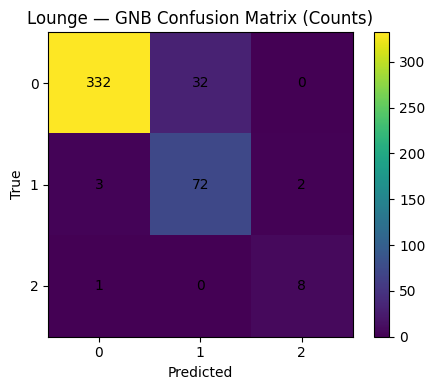

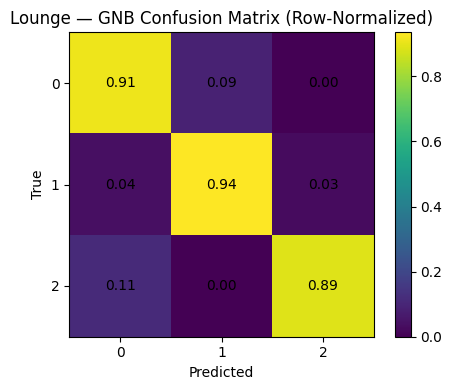

In [7]:
# ============================
# Code 1: Gaussian Naive Bayes — Lounge
# ============================

import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    classification_report,
)

BASE_DIR = "/content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS"
TRAIN_CSV = os.path.join(BASE_DIR, "lounge_train_proc_sass.csv")   # SASS-balanced train
TEST_CSV  = os.path.join(BASE_DIR, "lounge_test_proc.csv")         # original test

TARGET_COL = "satisfaction_class"

# ---------- Load CSVs ----------
def load_numeric_csv(path, target_col):
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        header = reader.fieldnames
        rows = [r for r in reader]

    if target_col not in header:
        raise ValueError(f"{target_col} not in {path}")

    features = [c for c in header if c != target_col]
    X = []
    y = []
    for row in rows:
        feat_vec = []
        for c in features:
            try:
                feat_vec.append(float(row[c]))
            except:
                feat_vec.append(0.0)
        X.append(feat_vec)
        y.append(int(float(row[target_col])))

    return np.array(X, dtype=np.float32), np.array(y, dtype=int), features

X_train, y_train, feat_cols = load_numeric_csv(TRAIN_CSV, TARGET_COL)
X_test,  y_test,  _         = load_numeric_csv(TEST_CSV,  TARGET_COL)

print("GNB — X_train shape:", X_train.shape)
print("GNB — X_test shape :", X_test.shape)

# ---------- Train GaussianNB ----------
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred  = gnb.predict(X_test)
y_proba = gnb.predict_proba(X_test)

classes = gnb.classes_
print("Classes:", classes)

# ---------- Metrics ----------
acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro"
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted"
)
ll = log_loss(y_test, y_proba, labels=classes)

# Brier (multi-class)
Y_true_oh = np.zeros_like(y_proba)
for i, yi in enumerate(y_test):
    cls_idx = np.where(classes == yi)[0][0]
    Y_true_oh[i, cls_idx] = 1.0
brier = np.mean(np.sum((y_proba - Y_true_oh) ** 2, axis=1))

print("\n=== Lounge — GaussianNB (SASS numeric) — Test Metrics ===")
print(f"Accuracy          : {acc:.4f}")
print(f"Macro Precision   : {prec_macro:.4f}")
print(f"Macro Recall      : {rec_macro:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_weighted:.4f}")
print(f"Weighted Recall   : {rec_weighted:.4f}")
print(f"Weighted F1       : {f1_weighted:.4f}")
print(f"Log-Loss          : {ll:.4f}")
print(f"Brier Score       : {brier:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ---------- Confusion Matrices ----------
cm = confusion_matrix(y_test, y_pred, labels=classes)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

tick_marks = np.arange(len(classes))

# Counts
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Lounge — GNB Confusion Matrix (Counts)")
plt.colorbar()
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Normalized
plt.figure(figsize=(5, 4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Lounge — GNB Confusion Matrix (Row-Normalized)")
plt.colorbar()
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Multinomial Naive Bayes (MNB) on SASS-balanced

MNB — X_train shape: (4377, 132)
MNB — X_test shape : (450, 132)
Classes: [0 1 2]

=== Lounge — MultinomialNB (SASS BoC) — Test Metrics ===
Accuracy          : 0.5689
Macro Precision   : 0.4076
Macro Recall      : 0.3846
Macro F1          : 0.3742
Weighted Precision: 0.7797
Weighted Recall   : 0.5689
Weighted F1       : 0.6420
Log-Loss          : 1.4187
Brier Score       : 0.624890

Classification Report:
              precision    recall  f1-score   support

           0     0.8945    0.5824    0.7055       364
           1     0.3284    0.5714    0.4171        77
           2     0.0000    0.0000    0.0000         9

    accuracy                         0.5689       450
   macro avg     0.4076    0.3846    0.3742       450
weighted avg     0.7797    0.5689    0.6420       450


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[212  88  64]
 [ 18  44  15]
 [  7   2   0]]


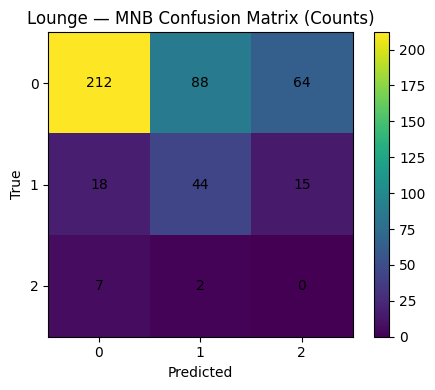

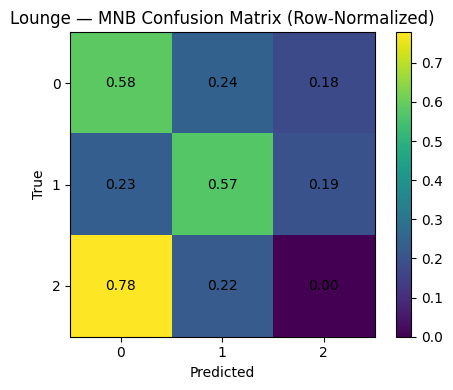

In [8]:
# ==========================================
# Code 2: Multinomial Naive Bayes — Lounge
# ==========================================

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    classification_report,
)

BASE_DIR = "/content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS"

X_TRAIN_SASS = os.path.join(BASE_DIR, "X_train_boc_sass.npy")
Y_TRAIN_SASS = os.path.join(BASE_DIR, "y_train_sass.npy")

X_TEST_FILE  = os.path.join(BASE_DIR, "X_test_boc.npy")
Y_TEST_FILE  = os.path.join(BASE_DIR, "y_test.npy")

# ---------- Load data ----------
X_train = np.load(X_TRAIN_SASS)
y_train = np.load(Y_TRAIN_SASS)
X_test  = np.load(X_TEST_FILE)
y_test  = np.load(Y_TEST_FILE)

print("MNB — X_train shape:", X_train.shape)
print("MNB — X_test shape :", X_test.shape)

# ---------- Train MultinomialNB ----------
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_pred  = mnb.predict(X_test)
y_proba = mnb.predict_proba(X_test)

classes = mnb.classes_
print("Classes:", classes)

# ---------- Metrics ----------
acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro"
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted"
)
ll = log_loss(y_test, y_proba, labels=classes)

Y_true_oh = np.zeros_like(y_proba)
for i, yi in enumerate(y_test):
    cls_idx = np.where(classes == yi)[0][0]
    Y_true_oh[i, cls_idx] = 1.0
brier = np.mean(np.sum((y_proba - Y_true_oh) ** 2, axis=1))

print("\n=== Lounge — MultinomialNB (SASS BoC) — Test Metrics ===")
print(f"Accuracy          : {acc:.4f}")
print(f"Macro Precision   : {prec_macro:.4f}")
print(f"Macro Recall      : {rec_macro:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_weighted:.4f}")
print(f"Weighted Recall   : {rec_weighted:.4f}")
print(f"Weighted F1       : {f1_weighted:.4f}")
print(f"Log-Loss          : {ll:.4f}")
print(f"Brier Score       : {brier:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ---------- Confusion Matrices ----------
cm = confusion_matrix(y_test, y_pred, labels=classes)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
tick_marks = np.arange(len(classes))

# Counts
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Lounge — MNB Confusion Matrix (Counts)")
plt.colorbar()
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Normalized
plt.figure(figsize=(5, 4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Lounge — MNB Confusion Matrix (Row-Normalized)")
plt.colorbar()
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Bernoulli Naive Bayes (BNB)

BNB — rows after cleaning: 2259
BNB — feature matrix shape: (2259, 1005)
BNB — #features: 1005
BNB — X_train shape: (1809, 1005)
BNB — X_test shape : (450, 1005)
Classes: [0 1 2]

=== Lounge — BernoulliNB (categorical) — Test Metrics ===
Accuracy          : 0.8044
Macro Precision   : 0.4203
Macro Recall      : 0.4066
Macro F1          : 0.4097
Weighted Precision: 0.7647
Weighted Recall   : 0.8044
Weighted F1       : 0.7817
Log-Loss          : 0.7899
Brier Score       : 0.303407

Classification Report:
              precision    recall  f1-score   support

           0     0.8608    0.9341    0.8959       364
           1     0.4000    0.2857    0.3333        77
           2     0.0000    0.0000    0.0000         9

    accuracy                         0.8044       450
   macro avg     0.4203    0.4066    0.4097       450
weighted avg     0.7647    0.8044    0.7817       450


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[340  24   0]
 [ 55  22   0]
 [  0   9   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

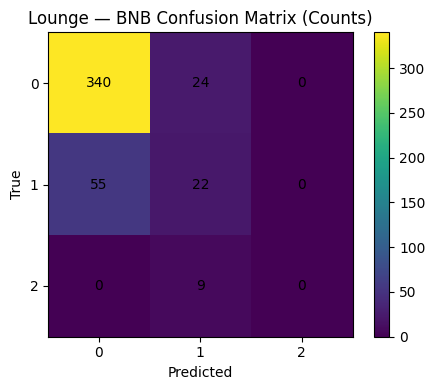

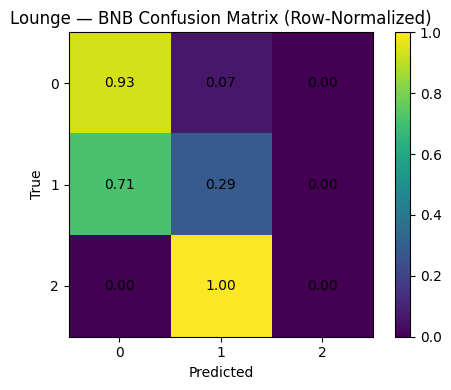

In [9]:
# ==========================================
# Code 3: Bernoulli Naive Bayes — Lounge
# ==========================================

import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    classification_report,
)

BASE_DIR   = "/content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS"
INPUT_CSV  = os.path.join(BASE_DIR, "lounge_with_target.csv")
TARGET_COL = "satisfaction_class"

categorical_cols = [
    "lounge_name",
    "airport",
    "lounge_type",
    "type_traveller",
    "recommended",
]

# ---------- Load & filter ----------
rows = []
with open(INPUT_CSV, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    header = reader.fieldnames
    for row in reader:
        rows.append(row)

clean_rows = []
for row in rows:
    v = row.get(TARGET_COL, "")
    ok = True
    try:
        vv = float(v)
        if vv == int(vv):
            vv = int(vv)
        else:
            ok = False
    except:
        ok = False

    if not ok or vv not in (0, 1, 2):
        continue

    has_cat = any(str(row.get(c, "")).strip() != "" for c in categorical_cols)
    if not has_cat:
        continue

    row[TARGET_COL] = vv
    clean_rows.append(row)

rows = clean_rows
print("BNB — rows after cleaning:", len(rows))

# ---------- DictVectorizer ----------
vec_dicts = []
labels = []
for r in rows:
    d = {}
    for c in categorical_cols:
        val = str(r.get(c, "")).strip()
        if val == "":
            val = "MISSING"
        d[f"{c}={val}"] = 1
    vec_dicts.append(d)
    labels.append(r[TARGET_COL])

labels = np.array(labels, dtype=int)

dv = DictVectorizer(sparse=False)
X_all = dv.fit_transform(vec_dicts)

print("BNB — feature matrix shape:", X_all.shape)
print("BNB — #features:", len(dv.feature_names_))

# ---------- Stratified 80/20 split ----------
idx0, idx1, idx2 = [], [], []
for i, y in enumerate(labels):
    if y == 0: idx0.append(i)
    elif y == 1: idx1.append(i)
    elif y == 2: idx2.append(i)

random.seed(42)
random.shuffle(idx0)
random.shuffle(idx1)
random.shuffle(idx2)

def split_idx(lst, test_ratio=0.20):
    n = len(lst)
    n_test = int(n * test_ratio)
    return lst[n_test:], lst[:n_test]

tr0, te0 = split_idx(idx0)
tr1, te1 = split_idx(idx1)
tr2, te2 = split_idx(idx2)

train_idx = tr0 + tr1 + tr2
test_idx  = te0 + te1 + te2

X_train = X_all[train_idx]
y_train = labels[train_idx]
X_test  = X_all[test_idx]
y_test  = labels[test_idx]

print("BNB — X_train shape:", X_train.shape)
print("BNB — X_test shape :", X_test.shape)

# ---------- Train BernoulliNB ----------
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

y_pred  = bnb.predict(X_test)
y_proba = bnb.predict_proba(X_test)

classes = bnb.classes_
print("Classes:", classes)

# ---------- Metrics ----------
acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro"
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted"
)
ll = log_loss(y_test, y_proba, labels=classes)

Y_true_oh = np.zeros_like(y_proba)
for i, yi in enumerate(y_test):
    cls_idx = np.where(classes == yi)[0][0]
    Y_true_oh[i, cls_idx] = 1.0
brier = np.mean(np.sum((y_proba - Y_true_oh) ** 2, axis=1))

print("\n=== Lounge — BernoulliNB (categorical) — Test Metrics ===")
print(f"Accuracy          : {acc:.4f}")
print(f"Macro Precision   : {prec_macro:.4f}")
print(f"Macro Recall      : {rec_macro:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_weighted:.4f}")
print(f"Weighted Recall   : {rec_weighted:.4f}")
print(f"Weighted F1       : {f1_weighted:.4f}")
print(f"Log-Loss          : {ll:.4f}")
print(f"Brier Score       : {brier:.6f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ---------- Confusion Matrices ----------
cm = confusion_matrix(y_test, y_pred, labels=classes)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
tick_marks = np.arange(len(classes))

# Counts
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Lounge — BNB Confusion Matrix (Counts)")
plt.colorbar()
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Normalized
plt.figure(figsize=(5, 4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Lounge — BNB Confusion Matrix (Row-Normalized)")
plt.colorbar()
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Hybrid (GNB + MNB)

Hybrid — Numeric X_train shape: (4377, 8)
Hybrid — Numeric X_test shape : (450, 8)
Hybrid — Text X_train shape: (4377, 132)
Hybrid — Text X_test shape : (450, 132)
Hybrid — Classes: [0 1 2]
alpha=0.1 -> LogLoss=0.8724, Acc=0.5956, MacroF1=0.3904
alpha=0.2 -> LogLoss=0.7136, Acc=0.6244, MacroF1=0.4059
alpha=0.3 -> LogLoss=0.6060, Acc=0.6778, MacroF1=0.4591
alpha=0.4 -> LogLoss=0.5238, Acc=0.7600, MacroF1=0.5306
alpha=0.5 -> LogLoss=0.4576, Acc=0.9044, MacroF1=0.8093
alpha=0.6 -> LogLoss=0.4032, Acc=0.9022, MacroF1=0.8505
alpha=0.7 -> LogLoss=0.3585, Acc=0.9044, MacroF1=0.8524
alpha=0.8 -> LogLoss=0.3234, Acc=0.9044, MacroF1=0.8524
alpha=0.9 -> LogLoss=0.3011, Acc=0.9067, MacroF1=0.8543

=== Lounge — Hybrid (GNB + MNB) — Best alpha ===
Best alpha   : 0.90
Best LogLoss : 0.3011
Accuracy          : 0.9067
Macro Precision   : 0.8182
Macro Recall      : 0.9084
Macro F1          : 0.8543
Weighted Precision: 0.9292
Weighted Recall   : 0.9067
Weighted F1       : 0.9124
Brier Score      : 0.1475

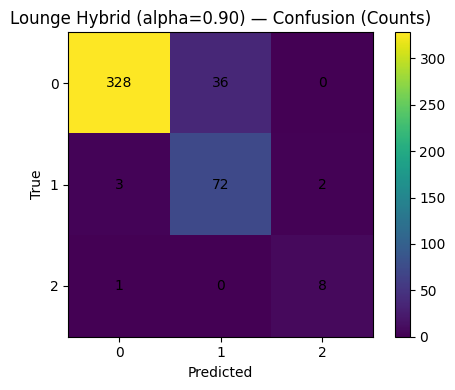

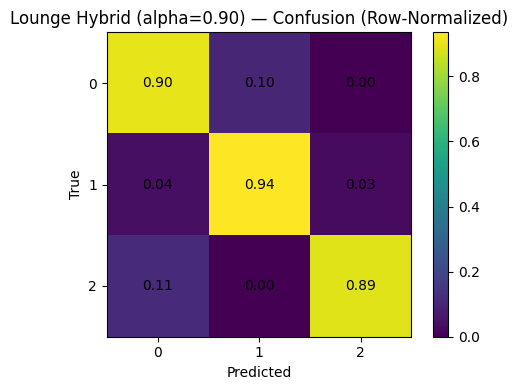

In [10]:
# ==========================================
# Code 4: Hybrid Model (GNB + MNB) — Lounge
# ==========================================

import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    log_loss,
    confusion_matrix,
    classification_report,
)

BASE_DIR = "/content/drive/MyDrive/PR_Sky/SASS/Data/Lounge_Dataset_work_SASS"

# Numeric
NUM_TRAIN_CSV = os.path.join(BASE_DIR, "lounge_train_proc_sass.csv")
NUM_TEST_CSV  = os.path.join(BASE_DIR, "lounge_test_proc.csv")

# Text
X_TRAIN_SASS = os.path.join(BASE_DIR, "X_train_boc_sass.npy")
Y_TRAIN_SASS = os.path.join(BASE_DIR, "y_train_sass.npy")
X_TEST_BOC   = os.path.join(BASE_DIR, "X_test_boc.npy")
Y_TEST       = os.path.join(BASE_DIR, "y_test.npy")

TARGET_COL = "satisfaction_class"

def load_numeric_csv(path, target_col):
    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        header = reader.fieldnames
        rows = [r for r in reader]

    if target_col not in header:
        raise ValueError(f"{target_col} not in {path}")

    features = [c for c in header if c != target_col]
    X = []
    y = []
    for row in rows:
        feat_vec = []
        for c in features:
            try:
                feat_vec.append(float(row[c]))
            except:
                feat_vec.append(0.0)
        X.append(feat_vec)
        y.append(int(float(row[target_col])))

    return np.array(X, dtype=np.float32), np.array(y, dtype=int), features

# ---------- Load numeric ----------
X_train_num, y_train_num, feat_cols = load_numeric_csv(NUM_TRAIN_CSV, TARGET_COL)
X_test_num,  y_test_num,  _         = load_numeric_csv(NUM_TEST_CSV,  TARGET_COL)

print("Hybrid — Numeric X_train shape:", X_train_num.shape)
print("Hybrid — Numeric X_test shape :", X_test_num.shape)

# ---------- Load text ----------
X_train_text = np.load(X_TRAIN_SASS)
y_train_text = np.load(Y_TRAIN_SASS)
X_test_text  = np.load(X_TEST_BOC)
y_test_text  = np.load(Y_TEST)

print("Hybrid — Text X_train shape:", X_train_text.shape)
print("Hybrid — Text X_test shape :", X_test_text.shape)

# Sanity
if not np.array_equal(y_test_num, y_test_text):
    print("WARNING: y_test from numeric and text views differ! Hybrid assumes same ordering.")

y_test = y_test_num

# ---------- Train base models ----------
gnb = GaussianNB()
gnb.fit(X_train_num, y_train_num)

mnb = MultinomialNB()
mnb.fit(X_train_text, y_train_text)

P_gnb = gnb.predict_proba(X_test_num)
P_mnb = mnb.predict_proba(X_test_text)

classes_gnb = gnb.classes_
classes_mnb = mnb.classes_
if not np.array_equal(classes_gnb, classes_mnb):
    raise ValueError("GNB and MNB classes differ; align required.")
classes = classes_gnb
print("Hybrid — Classes:", classes)

# ---------- Sweep alpha ----------
alphas = [i / 10.0 for i in range(1, 10)]
best_alpha = None
best_ll = None
best_metrics = None
best_y_pred = None
best_P_h = None

for alpha in alphas:
    P_h = alpha * P_gnb + (1.0 - alpha) * P_mnb

    eps = 1e-15
    P_h = np.clip(P_h, eps, 1.0 - eps)
    P_h = P_h / P_h.sum(axis=1, keepdims=True)

    ll = log_loss(y_test, P_h, labels=classes)
    y_pred = classes[np.argmax(P_h, axis=1)]
    acc = accuracy_score(y_test, y_pred)
    _, _, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average="macro"
    )

    print(f"alpha={alpha:.1f} -> LogLoss={ll:.4f}, Acc={acc:.4f}, MacroF1={f1_macro:.4f}")

    if (best_ll is None) or (ll < best_ll):
        best_ll = ll
        best_alpha = alpha
        best_P_h = P_h
        best_y_pred = y_pred

        prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
            y_test, y_pred, average="macro"
        )
        prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
            y_test, y_pred, average="weighted"
        )
        best_metrics = (acc, prec_macro, rec_macro, f1_macro,
                        prec_weighted, rec_weighted, f1_weighted)

print("\n=== Lounge — Hybrid (GNB + MNB) — Best alpha ===")
print(f"Best alpha   : {best_alpha:.2f}")
print(f"Best LogLoss : {best_ll:.4f}")

acc, prec_macro, rec_macro, f1_macro, prec_weighted, rec_weighted, f1_weighted = best_metrics
print(f"Accuracy          : {acc:.4f}")
print(f"Macro Precision   : {prec_macro:.4f}")
print(f"Macro Recall      : {rec_macro:.4f}")
print(f"Macro F1          : {f1_macro:.4f}")
print(f"Weighted Precision: {prec_weighted:.4f}")
print(f"Weighted Recall   : {rec_weighted:.4f}")
print(f"Weighted F1       : {f1_weighted:.4f}")

# Brier
Y_true_oh = np.zeros_like(best_P_h)
for i, yi in enumerate(y_test):
    cls_idx = np.where(classes == yi)[0][0]
    Y_true_oh[i, cls_idx] = 1.0
brier = np.mean(np.sum((best_P_h - Y_true_oh) ** 2, axis=1))
print(f"Brier Score      : {brier:.6f}")

print("\nClassification Report (Hybrid):")
print(classification_report(y_test, best_y_pred, digits=4))

# ---------- Confusion Matrices ----------
cm = confusion_matrix(y_test, best_y_pred, labels=classes)
print("\nHybrid — Confusion Matrix (counts):\n", cm)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
tick_marks = np.arange(len(classes))

# Counts
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title(f"Lounge Hybrid (alpha={best_alpha:.2f}) — Confusion (Counts)")
plt.colorbar()
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Normalized
plt.figure(figsize=(5, 4))
plt.imshow(cm_norm, interpolation="nearest")
plt.title(f"Lounge Hybrid (alpha={best_alpha:.2f}) — Confusion (Row-Normalized)")
plt.colorbar()
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
